In [19]:
import os
import time
import torch
import subprocess as sp
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

%matplotlib inline

In [20]:
base_path = sp.getoutput('git rev-parse --show-toplevel')
os.chdir(base_path)

from src import embed, pred_models, model_helpers

### Data Preparation

In [21]:
# Load data
data_dir = 'data'
file = 'utterances_clean2014-2018.csv'
df_raw = pd.read_csv(os.path.join(base_path, data_dir, file))

/var/folders/1r/lbtr12kn1_x17pfbmlxcjxf40000gn/T/ipykernel_65626/2014623051.py:4: DtypeWarning: Columns (17,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(os.path.join(base_path, data_dir, file))


In [22]:
# Have to do by utterance as grouping by case_id gives too few examples to learn from
df = df_raw[['text', 'win_side', 'case_id']]
df.head()

,text,win_side,case_id
0,"We'll hear argument next in Case No. 13-553, t...",1.0,2014_13-553
1,"Thank you, Mr. Chief Justice, and may it pleas...",1.0,2014_13-553
2,"Well, is said that -- it said that in -- in (b...",1.0,2014_13-553
3,Right. I -- but I think--,1.0,2014_13-553
4,"Another tax that discriminates is all it says,...",1.0,2014_13-553


In [23]:
# TO DISCUSS
df.dropna(subset=['win_side'], inplace=True)
df = df[df.win_side != 2]

/var/folders/1r/lbtr12kn1_x17pfbmlxcjxf40000gn/T/ipykernel_65626/1009847024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['win_side'], inplace=True)


In [24]:
# Split the dataset into training and testing sets
#train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)

# Assuming you already have a dataframe `df` with a 'case_id' column

# Get unique case_ids
unique_case_ids = df['case_id'].unique()

# Split the unique case_ids into training and testing sets
train_case_ids, test_case_ids = train_test_split(unique_case_ids, test_size=0.2, random_state=123)

# Filter the original dataframe to create the train and test dataframes using the train and test case_ids
train_df = df[df['case_id'].isin(train_case_ids)]
test_df = df[df['case_id'].isin(test_case_ids)]


In [25]:
display(train_case_ids.shape)
display(test_case_ids.shape)

(251,)

(63,)

### BoW Embedding

In [26]:
# Bag of Words
vocab = embed.get_vocab(train_df, min_freq=10)
vocab_size = len(vocab)
vocab_size

7995

### Create training, validation, and testing dataloaders

In [27]:
BATCH_SIZE = 64

train_df = train_df[['text', 'win_side']] # Remove case ID for training
train_valid_data = list(train_df.values)
num_train = int(len(train_valid_data) * 0.95)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])
test_data = list(test_df[['text', 'win_side']].values)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab)) # pass vocab to collate function
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=lambda batch: embed.collate_into_bow(batch, vocab))

### Training

In [28]:
# BoW NN Classifier
hidden_dim = 300
model = pred_models.BoWNNClassifier(vocab_size=vocab_size, hidden_dim=hidden_dim, output_dim=1)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


At iteration 200 the loss is 0.686.
At iteration 400 the loss is 0.584.
At iteration 600 the loss is 0.565.
At iteration 800 the loss is 0.565.
After epoch 1 the validation accuracy is 0.724.


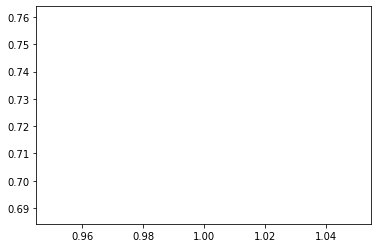

In [29]:
EPOCHS = 15
loss_function = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

best_model = None
best_acc = 0
accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    model_helpers.train_an_epoch(model, train_dataloader, optimizer, loss_function)
    accuracy = model_helpers.get_accuracy(model, valid_dataloader, 0.5)
    if accuracy > best_acc:
        best_model = type(model)(model.vocab_size, model.hidden_dim, model.output_dim) # get a new instance
        best_model.load_state_dict(model.state_dict())
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    
plt.plot(range(1, EPOCHS+1), accuracies)

### Evaluation

In [30]:
# Get dataframe with predictions and real values
test_results_df = model_helpers.get_test_results_df(best_model, test_dataloader, test_df[['case_id', 'win_side']])
test_results_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/_tensor.py:775: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


,case_id,win_side,labels,prob
2352,2014_13-894,0.0,0.0,0.443445
2353,2014_13-894,0.0,0.0,0.869779
2354,2014_13-894,0.0,0.0,0.673270
2355,2014_13-894,0.0,0.0,0.933395
2356,2014_13-894,0.0,0.0,0.504069


In [31]:
# Results dataframe per utterance
per_utterance_df = (test_results_df
                    .assign(pred=lambda x: x['prob']
                    .apply(lambda y: 1 if y > 0.5 else 0)))

# petitioner 1, respondent 0
display(per_utterance_df.pred.value_counts())
per_utterance_df.win_side.value_counts()

1    14055
0     1612
Name: pred, dtype: int64

1.0    9666
0.0    6001
Name: win_side, dtype: int64

In [32]:
# Results dataframe per case
per_case_df = (test_results_df
                .groupby('case_id')
                .mean()
                .assign(pred=lambda x: x['prob']
                .apply(lambda y: 1 if y > 0.5 else 0)))

# petitioner 1, respondent 0
display(per_case_df.pred.value_counts())
per_case_df.win_side.value_counts()

1    63
Name: pred, dtype: int64

1.0    38
0.0    25
Name: win_side, dtype: int64

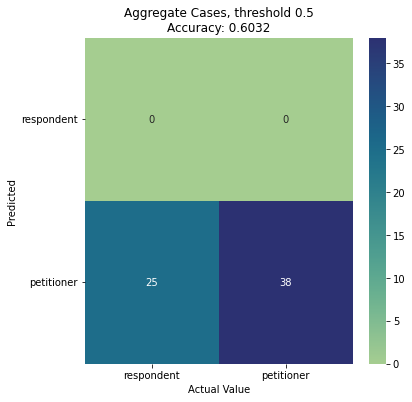

In [33]:
# Confusion matrix by case
model_helpers.results_heatmap(per_case_df['pred'],
                per_case_df['win_side'],
                'Aggregate Cases, threshold 0.5',
                target_names = ['respondent', 'petitioner'])

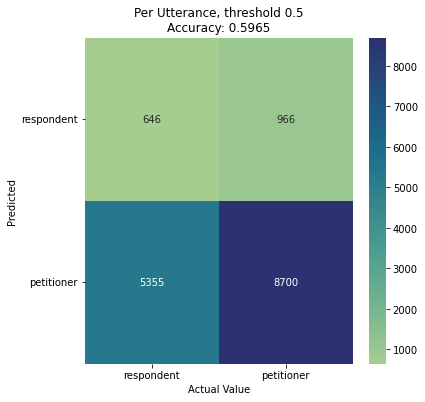

In [34]:
# Confusion matrix by utterance
model_helpers.results_heatmap(per_utterance_df['pred'],
                per_utterance_df['win_side'],
                'Per Utterance, threshold 0.5',
                target_names = ['respondent', 'petitioner'])